# Introduction
This project is aimed at building a propensity model to identify potential customers.
The insurance company has provided you with a historical data set (train.csv). The company has also provided you with a list of potential customers to whom to market (test.csv). 

In [201]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [202]:
# Load historical data
df_train = pd.read_excel(r"C:\Users\Zimm\Downloads\Propensify\train.xlsx")

# Load potential customer data
df_test = pd.read_excel(r"C:\Users\Zimm\Downloads\Propensify\test.xlsx")

In [203]:
df_train.shape

(8240, 24)

In [204]:
# Checking the columns in dataset
df_train.columns

Index(['custAge', 'profession', 'marital', 'schooling', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths', 'pastEmail',
       'responded', 'profit', 'id'],
      dtype='object')

In [205]:
df_train.describe()

,custAge,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,profit,id
count,6224.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,930.000000,8238.000000
mean,39.953728,2.531682,960.916606,0.183054,0.056397,93.570977,-40.577907,3.586929,5165.575965,960.687436,0.365501,77.709677,4119.500000
std,10.540516,2.709773,190.695054,0.514209,1.566550,0.578782,4.650101,1.742784,72.727423,191.841012,1.294101,2881.768500,2378.250092
min,18.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,-87622.112070,1.000000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,999.000000,0.000000,124.000000,2060.250000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000,999.000000,0.000000,170.000000,4119.500000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,999.000000,0.000000,213.000000,6178.750000
max,94.000000,40.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,999.000000,25.000000,515.000000,8238.000000


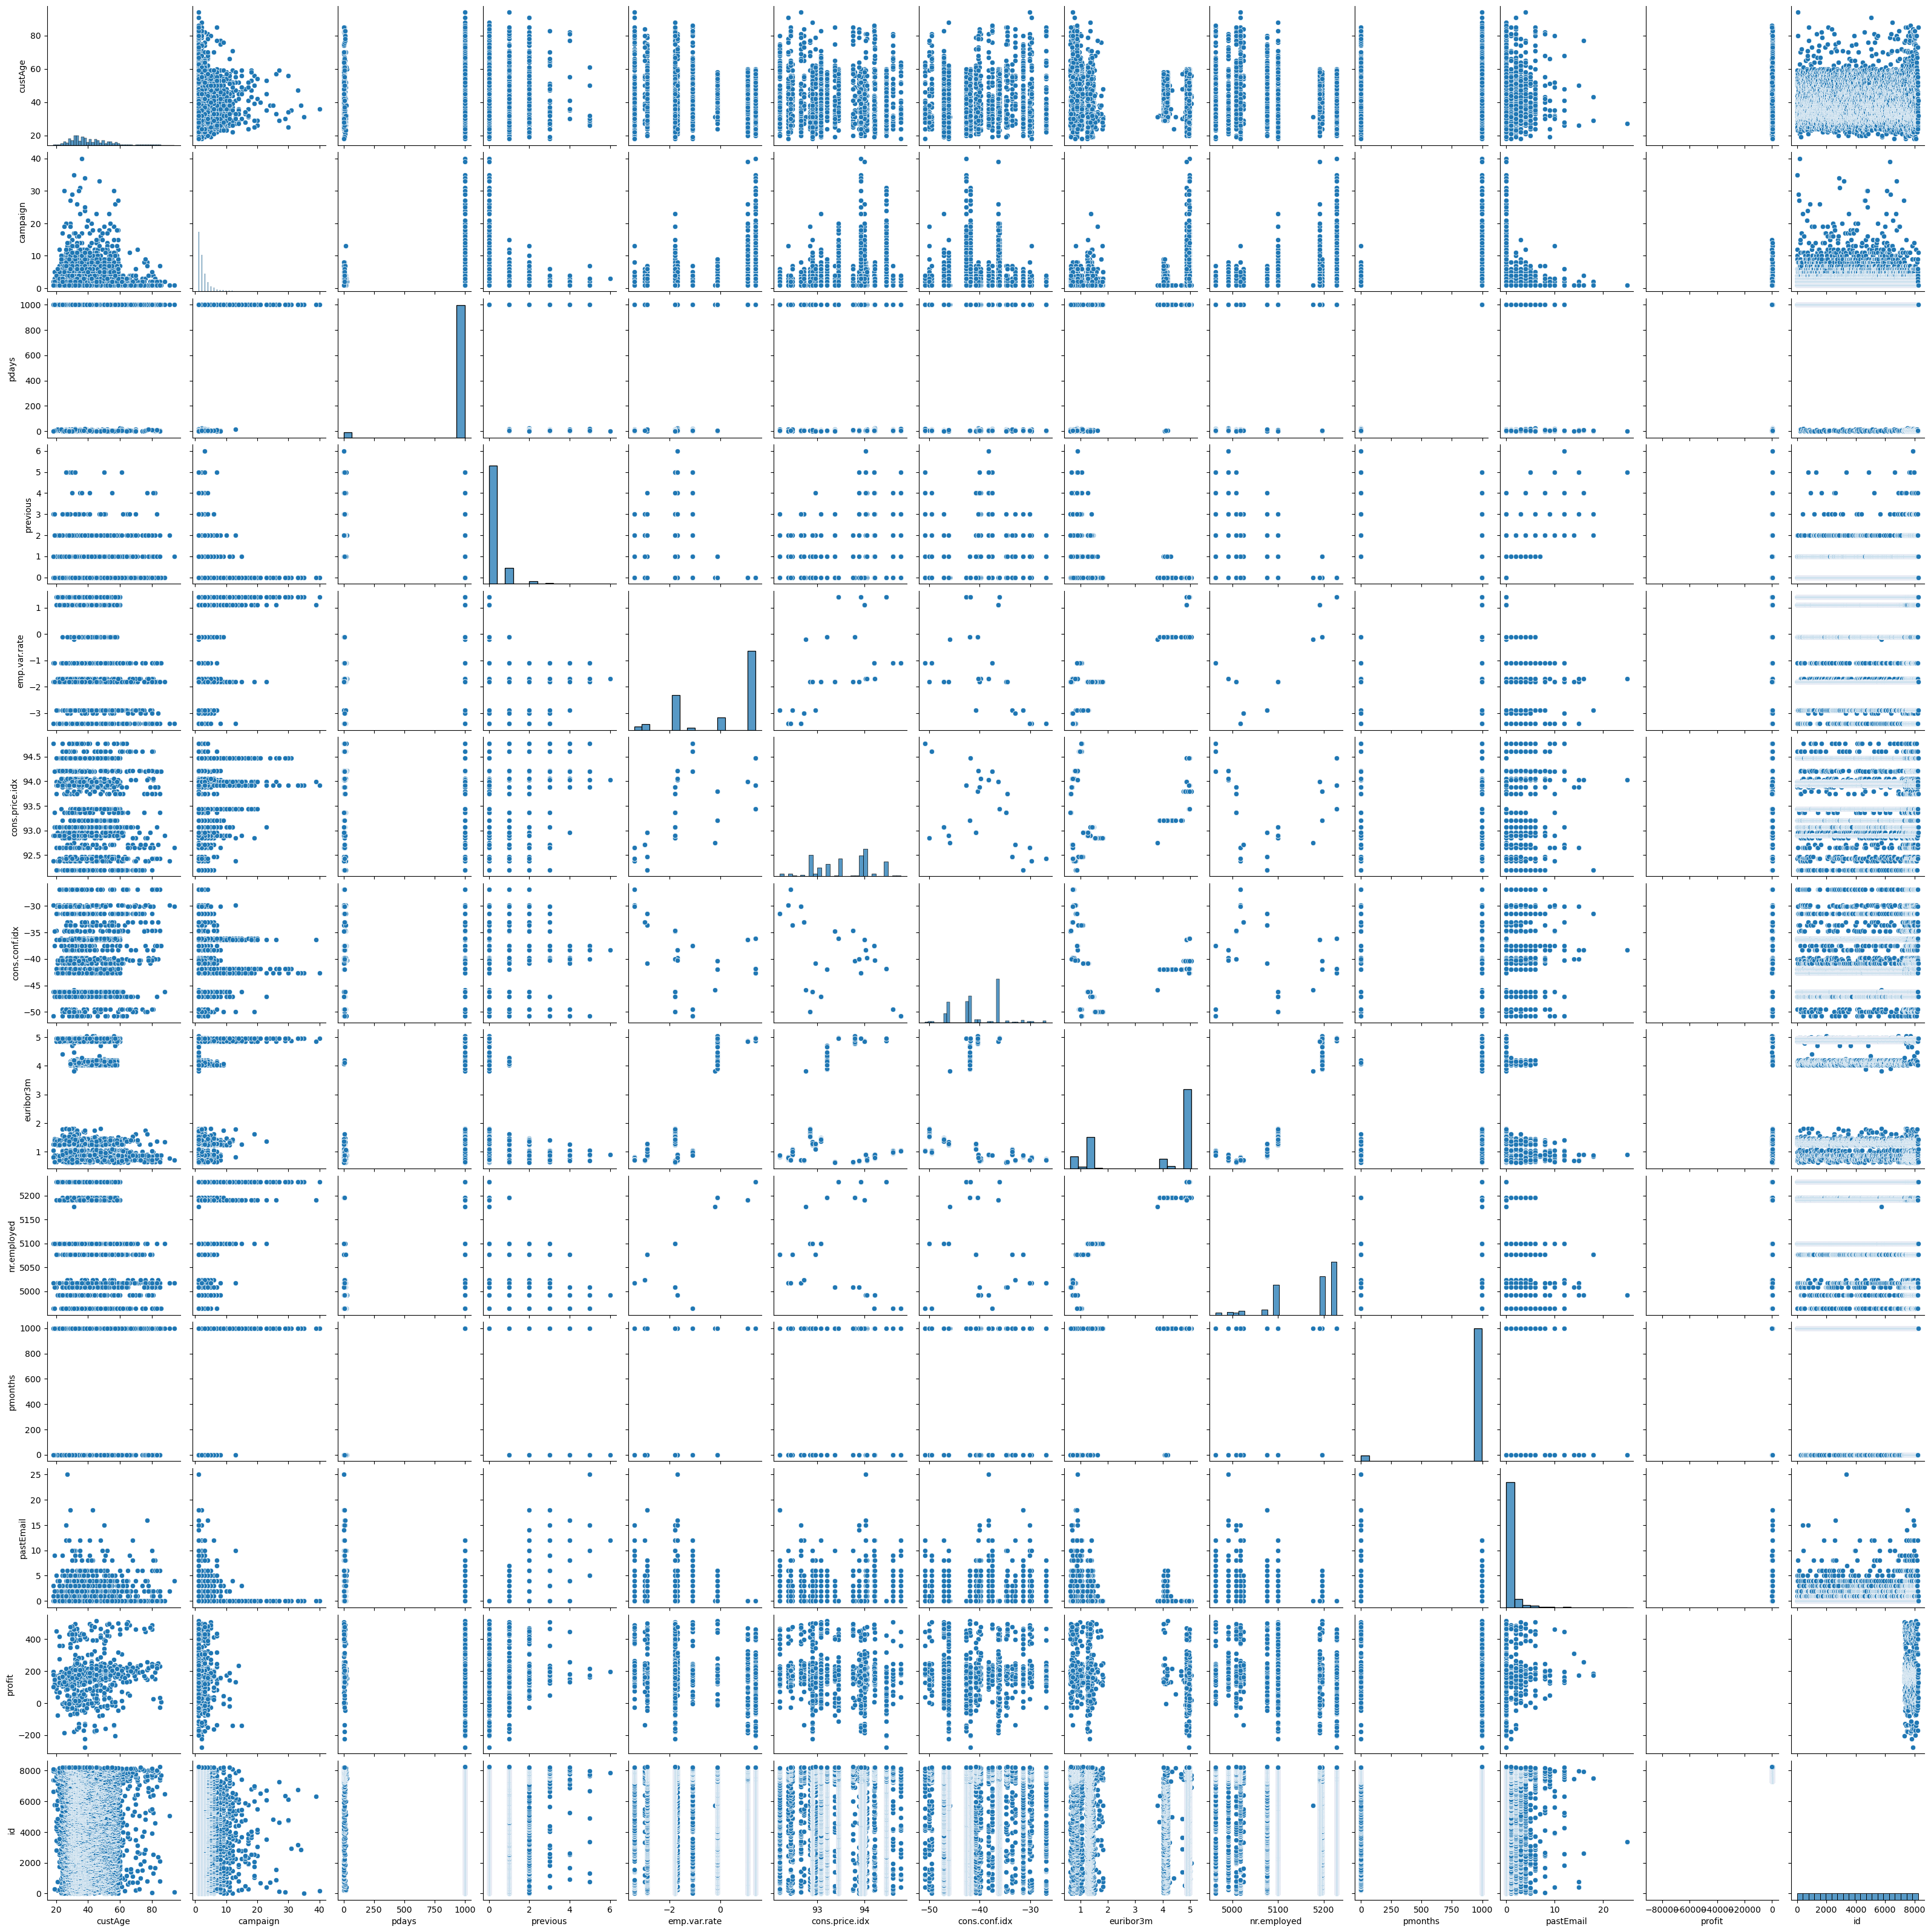

In [206]:
# Data visualization
# Pairplot to visualize relationships between numerical variables
sns.pairplot(df_train)
plt.show()

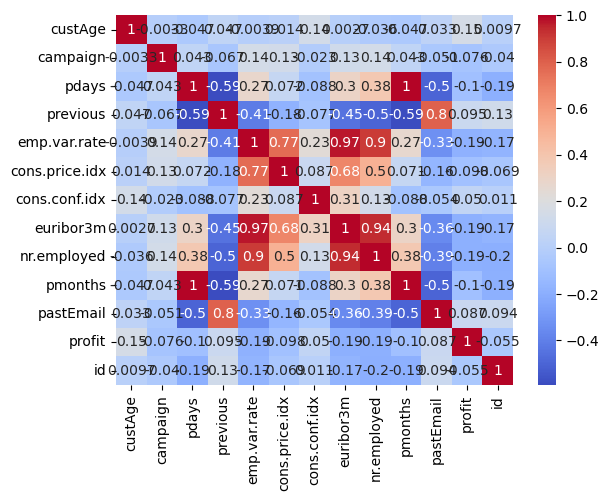

In [207]:
# Correlation heatmap to identify relationships between variables
correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

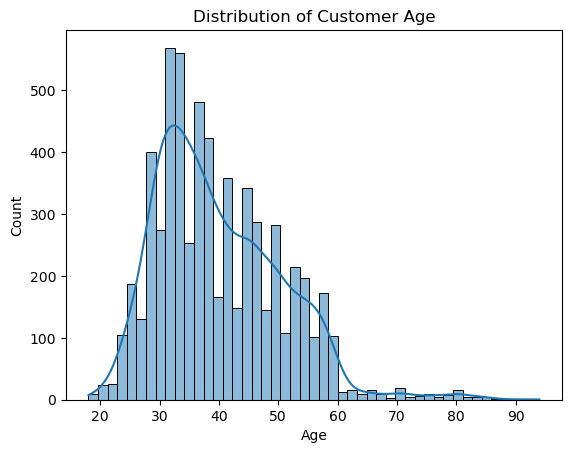

In [208]:
# Distribution of a numerical variable
sns.histplot(df_train['custAge'], kde=True)
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

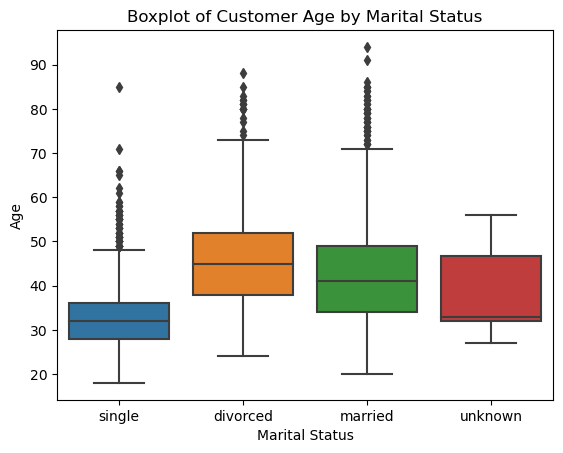

In [209]:
# Boxplot to identify outliers and distribution of a numerical variable
sns.boxplot(x='marital', y='custAge', data=df_train)
plt.title('Boxplot of Customer Age by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Age')
plt.show()

In [210]:
# Calculate value counts
value_counts = df_train['responded'].value_counts()

# Calculate percentages
percentages = value_counts / len(df_train) * 100


# Display the result
print(percentages)

no     88.713592
yes    11.262136
Name: responded, dtype: float64


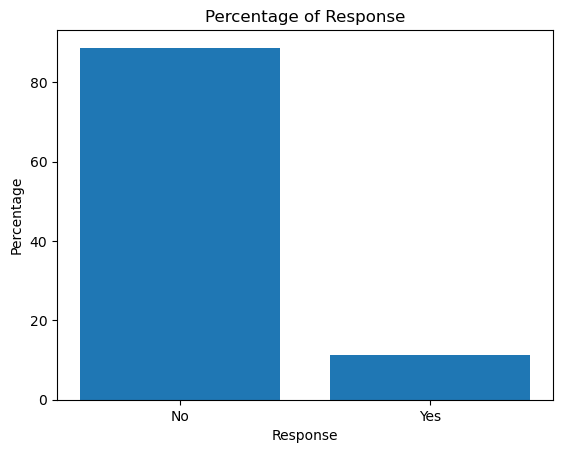

In [211]:
# Create a bar plot
plt.bar(percentages.index, percentages.values)
plt.xlabel('Response')
plt.ylabel('Percentage')
plt.title('Percentage of Response')
plt.xticks([0, 1], ['No', 'Yes'])  # Assuming 0 represents 'No' and 1 represents 'Yes'
plt.show()

In [212]:
# Keep only required columns
columns_to_keep = ['custAge', 'profession', 'marital', 'schooling', 'default', 'housing',
                   'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
                   'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                   'euribor3m', 'nr.employed', 'pmonths', 'pastEmail', 'responded']

df_train = df_train[columns_to_keep]
df_train.shape

(8240, 22)

# Data Cleaning

# Dealing with Imbalanced data

This might include standardization, handling the missing values and outliers in the data
This data set is highly imbalanced. The data should be balanced using the appropriate methods before moving onto model building.

In [213]:
# Check for missing values
missing_values = df_train.isnull().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
custAge           2016
profession           2
marital              2
schooling         2408
default              2
housing              2
loan                 2
contact              2
month                2
day_of_week        789
campaign             2
pdays                2
previous             2
poutcome             2
emp.var.rate         2
cons.price.idx       2
cons.conf.idx        2
euribor3m            2
nr.employed          2
pmonths              2
pastEmail            2
responded            2
dtype: int64


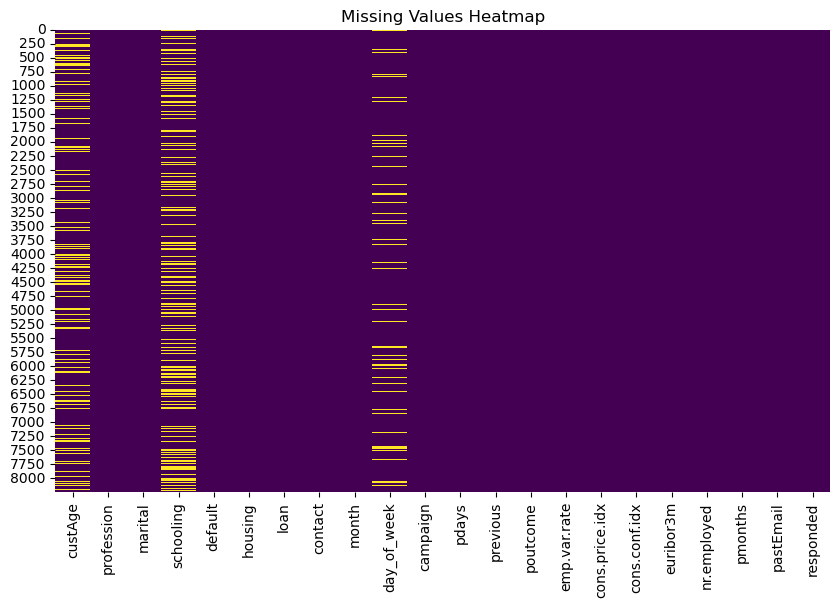

In [214]:
# Create a heatmap to visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df_train.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

In [215]:
# Checking duplicate values
print(df_train.duplicated().value_counts())

False    8203
True       37
dtype: int64


In [216]:
# Imputing missing values of schooling
cross_tab = pd.crosstab(df_train['schooling'], df_train['profession'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: pink' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

profession,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
schooling,,,,,,,,,,,,
basic.4y,2.047782,55.802048,4.436860,10.409556,2.389078,14.675768,1.706485,3.242321,0.341297,0.853242,2.730375,1.365188
basic.6y,8.626198,61.022364,1.597444,4.792332,4.472843,4.153355,0.000000,10.543131,0.638978,3.194888,0.958466,0.000000
basic.9y,7.184241,61.413673,3.012746,2.085747,2.201622,1.738123,4.287370,6.836616,0.926999,6.604867,3.128621,0.579374
high.school,36.268657,8.805970,2.686567,1.492537,3.358209,2.313433,1.567164,27.985075,3.358209,9.179104,2.686567,0.298507
illiterate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
professional.course,7.046070,9.756098,3.387534,1.761518,1.897019,4.065041,2.303523,4.065041,0.948509,62.466125,2.032520,0.271003
university.degree,47.198151,0.693241,5.661467,1.270942,16.811092,2.195263,5.430387,1.328712,1.213172,16.233391,1.559792,0.404391
unknown,16.538462,25.000000,3.461538,3.846154,6.923077,6.153846,1.923077,5.384615,9.230769,10.769231,0.384615,10.384615


In [217]:
# Feature engineering for schooling
schooling_category = {
    'basic.4y' : 'basic',
    'basic.6y' : 'basic',
    'basic.9y' : 'basic',
    'high.school': 'high.school',
    'illiterate':'illiterate',
    'professional.course': 'professional.course',
    'university.degree':'university.degree',
    'unknown':'unknown',
}

df_train['schooling'] = df_train['schooling'].replace(schooling_category)

In [218]:
cross_tab = pd.crosstab(df_train['schooling'], df_train['profession'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: pink' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

profession,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
schooling,,,,,,,,,,,,
basic,5.732123,59.477866,3.234960,5.334847,2.667423,6.469921,2.667423,6.299659,0.681044,4.086266,2.610670,0.737798
high.school,36.268657,8.805970,2.686567,1.492537,3.358209,2.313433,1.567164,27.985075,3.358209,9.179104,2.686567,0.298507
illiterate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
professional.course,7.046070,9.756098,3.387534,1.761518,1.897019,4.065041,2.303523,4.065041,0.948509,62.466125,2.032520,0.271003
university.degree,47.198151,0.693241,5.661467,1.270942,16.811092,2.195263,5.430387,1.328712,1.213172,16.233391,1.559792,0.404391
unknown,16.538462,25.000000,3.461538,3.846154,6.923077,6.153846,1.923077,5.384615,9.230769,10.769231,0.384615,10.384615


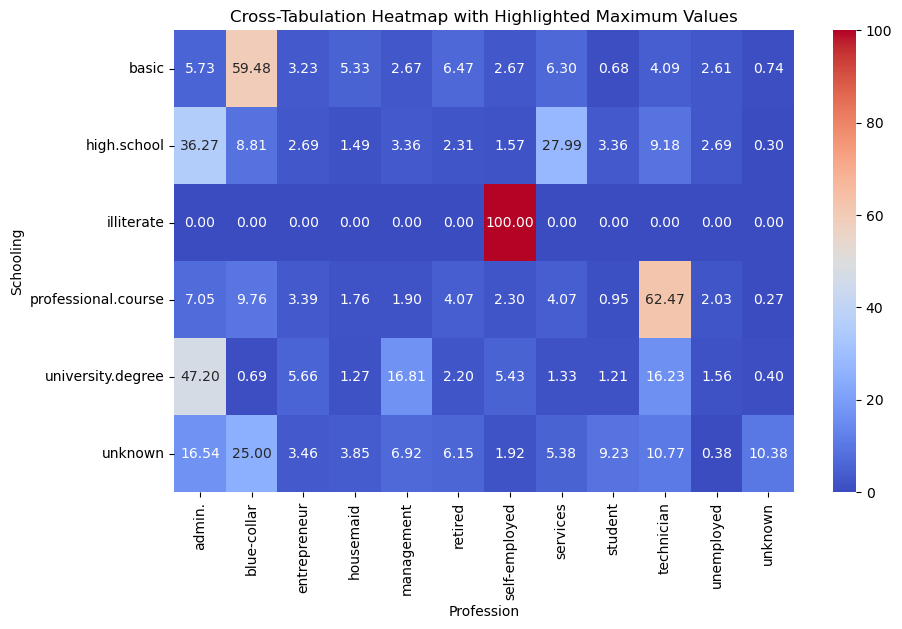

In [219]:
# Create the cross-tabulation with normalization
cross_tab = pd.crosstab(df_train['schooling'], df_train['profession'], normalize='index') * 100

# Create a heatmap with highlighted maximum values
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Cross-Tabulation Heatmap with Highlighted Maximum Values')
plt.xlabel('Profession')
plt.ylabel('Schooling')
plt.show()

In [220]:
# Imputing missing values in education based on profession

imputation_mapping = {
    'blue-collar' : 'basic',
    'self-employed': 'illiterate',
    'technician'   : 'professional.course',
    'admin.'        : 'university.degree',
    'services'      : 'high.school',
    'management'    : 'university.degree',
    'retired'       : 'unknown',
    'entrepreneur'  : 'university.degree'
}

df_train['schooling'] = df_train['schooling'].combine_first(df_train['profession'].map(imputation_mapping))

In [221]:
# Treating the missing values of profession
df_train['employment_status'] = df_train['profession'].apply(lambda x: 'retired' if x == 'retired' else ('student' if x == 'student' else 'working'))

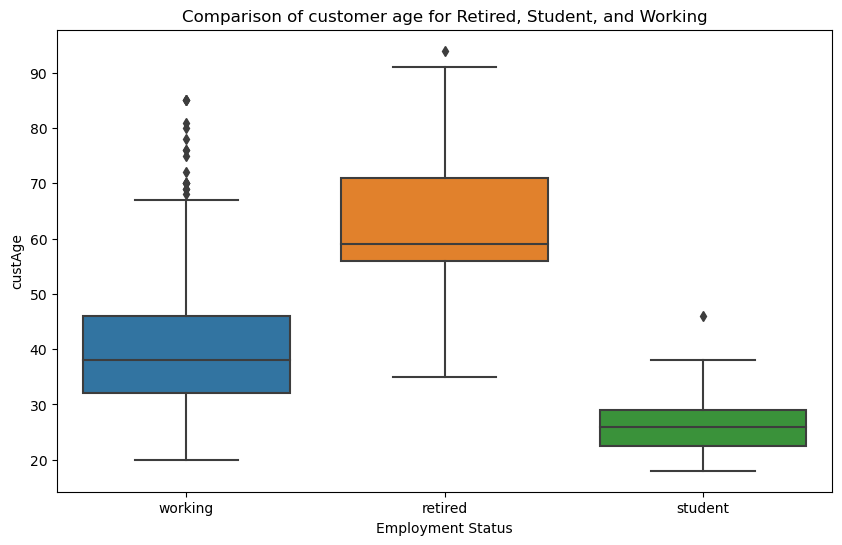

In [222]:
# Age comparision of Retired, Student and Working
plt.figure(figsize=(10, 6))
sns.boxplot(x='employment_status', y='custAge', data=df_train)
plt.title('Comparison of customer age for Retired, Student, and Working')
plt.xlabel('Employment Status')
plt.ylabel('custAge')
plt.show()

In [223]:
# Imputing age values
# Calculate mean and median values for each profession
mean_age_retired = df_train.loc[df_train['employment_status'] == 'retired', 'custAge'].mean()
mean_age_student = df_train.loc[df_train['employment_status'] == 'student', 'custAge'].mean()
median_age_working = df_train.loc[df_train['employment_status'] == 'working', 'custAge'].median()

# Fill missing values based on profession-specific mean or median
df_train['custAge'] = np.where((df_train['employment_status'] == 'retired') & df_train['custAge'].isna(), mean_age_retired, df_train['custAge'])
df_train['custAge'] = np.where((df_train['employment_status'] == 'student') & df_train['custAge'].isna(), mean_age_student, df_train['custAge'])
df_train['custAge'] = np.where((df_train['employment_status'] == 'working') & df_train['custAge'].isna(), median_age_working, df_train['custAge'])


In [224]:
# Imputing day of week variables which is based on random function
day_values = df_train['day_of_week'].value_counts()
print(day_values)

mon    1598
thu    1533
tue    1478
wed    1473
fri    1369
Name: day_of_week, dtype: int64


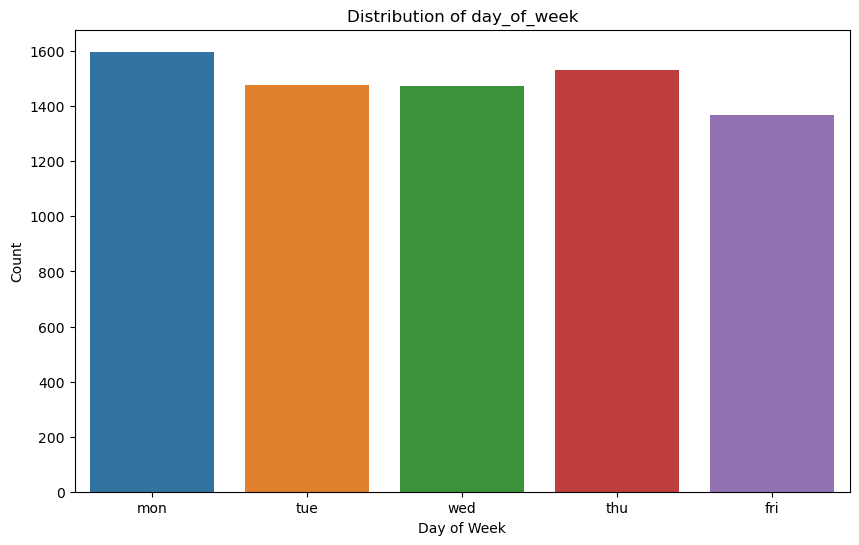

In [225]:
# Day of week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=df_train, order=['mon', 'tue', 'wed', 'thu', 'fri'])
plt.title('Distribution of day_of_week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.show()

In [226]:
cross_tab = pd.crosstab(df_train['day_of_week'], df_train['responded'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: pink' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

responded,no,yes
day_of_week,,
fri,88.093499,11.906501
mon,90.488110,9.511890
thu,87.932159,12.067841
tue,88.159675,11.840325
wed,89.341480,10.658520


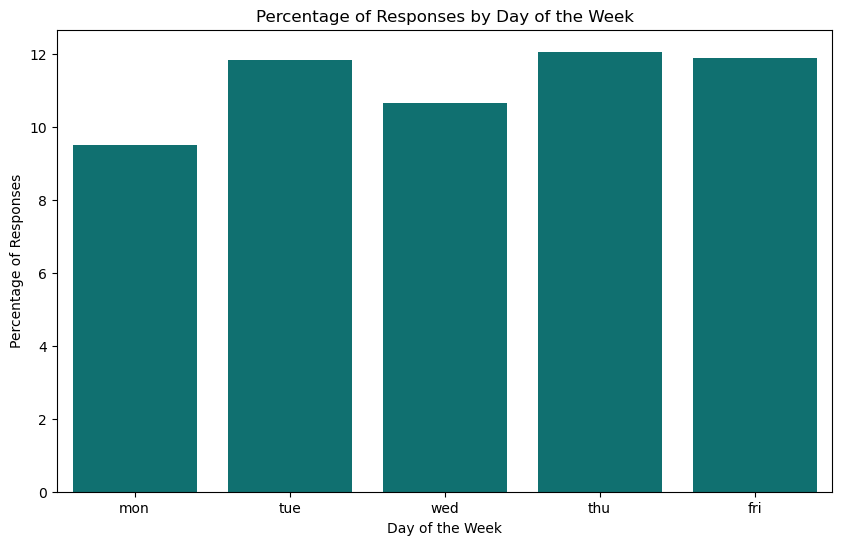

In [227]:
# Extracting the DataFrame from styled DataFrame object
cross_tab = pd.crosstab(df_train['day_of_week'], df_train['responded'], normalize='index') * 100

# Plotting the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=cross_tab, x=cross_tab.index, y='yes', color='teal', order=['mon', 'tue', 'wed', 'thu', 'fri'])
plt.title('Percentage of Responses by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Percentage of Responses')
plt.show()

In [228]:
def impute_random_day(day):
    if pd.isna(day):
        return np.random.choice(['mon', 'tue', 'wed', 'thu', 'fri'])
    else:
        return day

# Imputation function to the 'day_of_week' column
df_train['day_of_week'] = df_train['day_of_week'].apply(impute_random_day)

In [229]:
# Treat missing values
missing_values = df_train.isnull().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
custAge                0
profession             2
marital                2
schooling            189
default                2
housing                2
loan                   2
contact                2
month                  2
day_of_week            0
campaign               2
pdays                  2
previous               2
poutcome               2
emp.var.rate           2
cons.price.idx         2
cons.conf.idx          2
euribor3m              2
nr.employed            2
pmonths                2
pastEmail              2
responded              2
employment_status      0
dtype: int64


In [230]:
# Now dropping remaining missing values which is minimal
df_train = df_train.dropna()

In [231]:
# Re-check the missing values
missing_values = df_train.isnull().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
custAge              0
profession           0
marital              0
schooling            0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
pmonths              0
pastEmail            0
responded            0
employment_status    0
dtype: int64


In [232]:
df_train.shape

(8051, 23)

# Feature engineering of categorical variables:

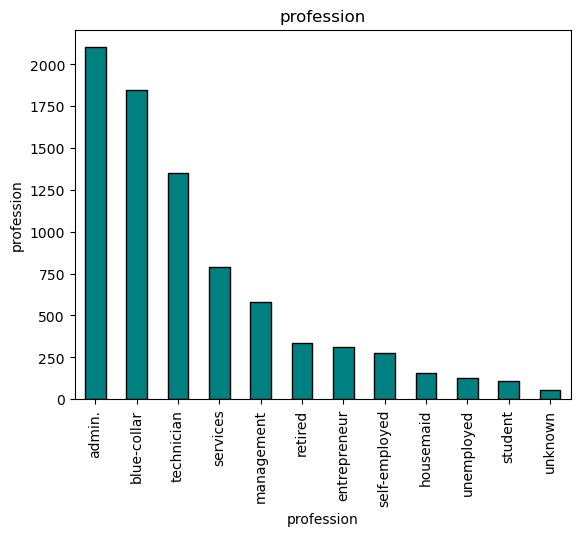

In [233]:
#1. Profession
df_train['profession'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title('profession')
plt.xlabel('profession')
plt.ylabel('profession')
plt.show()

In [234]:
cross_tab = pd.crosstab(df_train['profession'], df_train['responded'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: pink' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

responded,no,yes
profession,,
admin.,87.155090,12.844910
blue-collar,91.932864,8.067136
entrepreneur,90.764331,9.235669
housemaid,91.194969,8.805031
management,88.850772,11.149228
retired,76.557864,23.442136
self-employed,87.813620,12.186380
services,92.550505,7.449495
student,63.302752,36.697248


In [235]:
# Label encoding
df_train['profession'] = df_train['profession'].map({'student': 'Dependents', 'retired': 'Dependents', 'unemployed': 'Unemployed&Unknown', 'unknown': 'Unemployed&Unknown', 
                                                    'admin.': 'Working','blue-collar': 'Working','entrepreneur': 'Working','housemaid': 'Working',
                                                   'management': 'Working','self-employed': 'Working','services': 'Working','technician': 'Working'})

# Display the updated DataFrame
df_train['profession'].value_counts()

Working               7427
Dependents             446
Unemployed&Unknown     178
Name: profession, dtype: int64

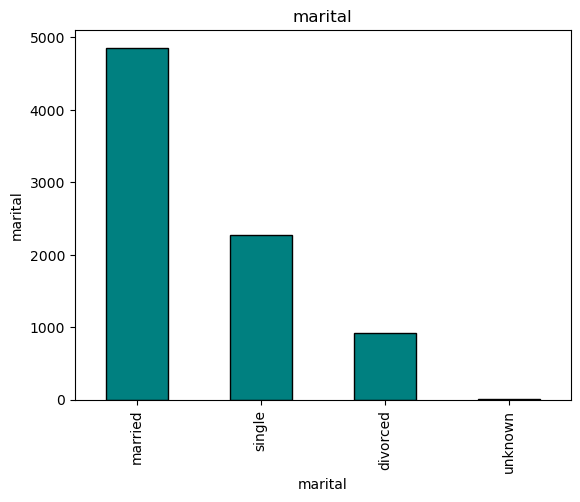

In [236]:
# Analyze Marital
df_train['marital'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title('marital')
plt.xlabel('marital')
plt.ylabel('marital')
plt.show()

In [237]:
cross_tab = pd.crosstab(df_train['marital'], df_train['responded'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: pink' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

responded,no,yes
marital,,
divorced,89.934354,10.065646
married,89.728283,10.271717
single,86.475771,13.524229
unknown,77.777778,22.222222


In [238]:
# Label encoding
df_train['marital'] = df_train['marital'].map({'single': 'Single&Divorced', 'divorced': 'Single&Divorced', 
                                                                     'married': 'married', 'unknown': 'Unknown', })

# Display the updated DataFrame
df_train['marital'].value_counts()

married            4858
Single&Divorced    3184
Unknown               9
Name: marital, dtype: int64

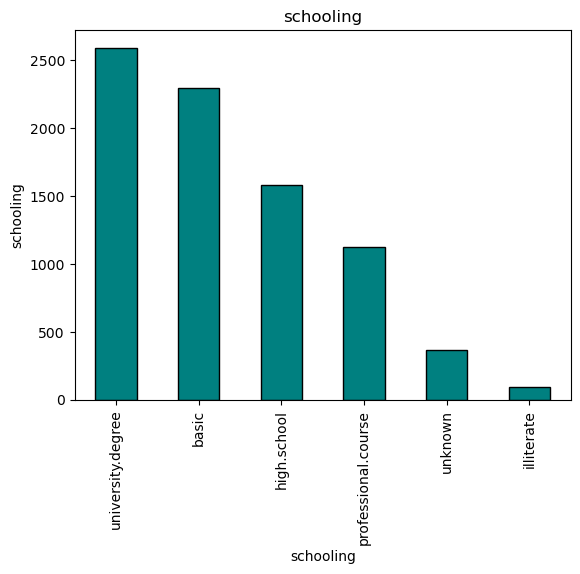

In [239]:
# Schooling
df_train['schooling'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title('schooling')
plt.xlabel('schooling')
plt.ylabel('schooling')
plt.show()

In [240]:
cross_tab = pd.crosstab(df_train['schooling'], df_train['responded'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: pink' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

responded,no,yes
schooling,,
basic,91.325196,8.674804
high.school,89.550348,10.449652
illiterate,87.368421,12.631579
professional.course,89.412811,10.587189
university.degree,87.032034,12.967966
unknown,81.250000,18.750000


In [241]:
# Label encoding
df_train['schooling'] = df_train['schooling'].map({'basic': 'Uneducated&BasicEducation', 'high.school': 'Uneducated&BasicEducation', 
                                                                     'illiterate': 'Uneducated&BasicEducation', 
                                                                   'unknown': 'Unknown',
                                                                  'professional.course': 'Educated',
                                                                  'university.degree': 'Educated',
                                                                  })

# Display the updated DataFrame
df_train['schooling'].value_counts()

Uneducated&BasicEducation    3968
Educated                     3715
Unknown                       368
Name: schooling, dtype: int64

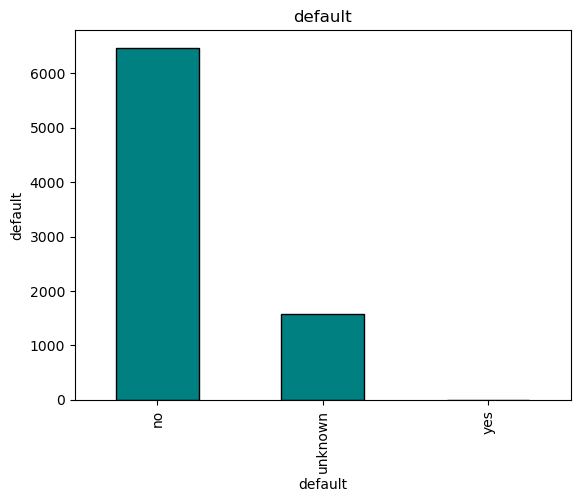

In [242]:
# Default
df_train['default'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title('default')
plt.xlabel('default')
plt.ylabel('default')
plt.show()

In [243]:
# Label encoding
df_train['default'] = df_train['default'].map({'no': 'No', 'unknown': 'Yes&Unknown','yes':'Yes&Unknown' })

# Display the updated DataFrame
df_train['default'].value_counts()

No             6470
Yes&Unknown    1581
Name: default, dtype: int64

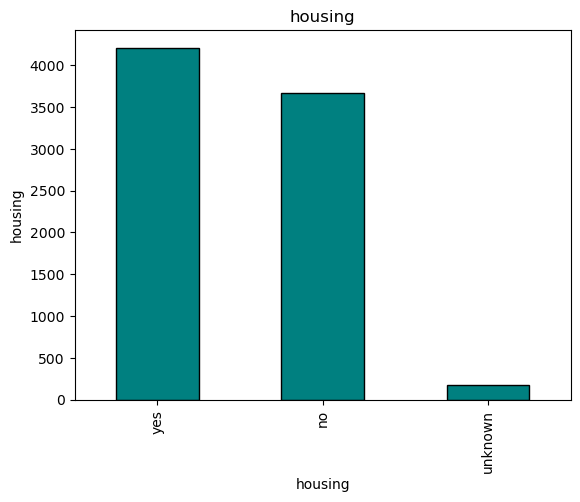

In [244]:
# Analyze Housing
df_train['housing'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title('housing')
plt.xlabel('housing')
plt.ylabel('housing')
plt.show()

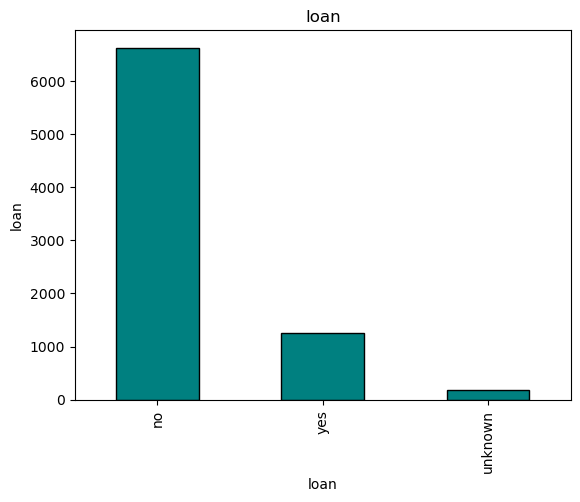

In [245]:
# Analyze loan
df_train['loan'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title('loan')
plt.xlabel('loan')
plt.ylabel('loan')
plt.show()

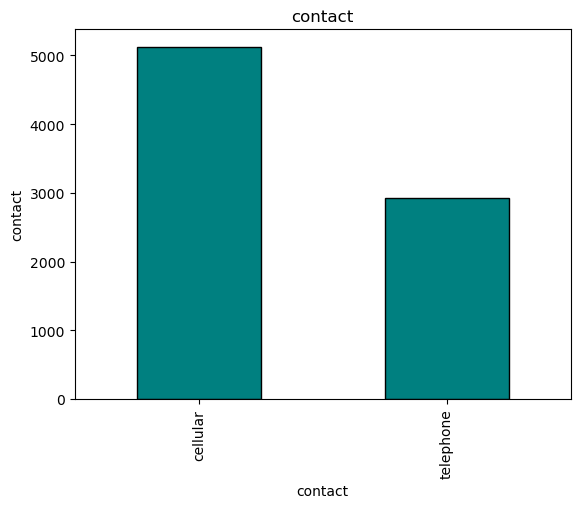

In [246]:
# Analyze contact
df_train['contact'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title('contact')
plt.xlabel('contact')
plt.ylabel('contact')
plt.show()

In [247]:
cross_tab = pd.crosstab(df_train['month'], df_train['responded'],normalize = 'index')*100
highlighted_cross_tab = cross_tab.style.apply(lambda x: ['background-color: pink' if val == x.max() else '' for val in x], axis=1)
highlighted_cross_tab

responded,no,yes
month,,
apr,77.094972,22.905028
aug,91.043550,8.956450
dec,44.827586,55.172414
jul,91.189759,8.810241
jun,90.155945,9.844055
mar,51.456311,48.543689
may,92.849365,7.150635
nov,91.898734,8.101266
oct,57.046980,42.953020


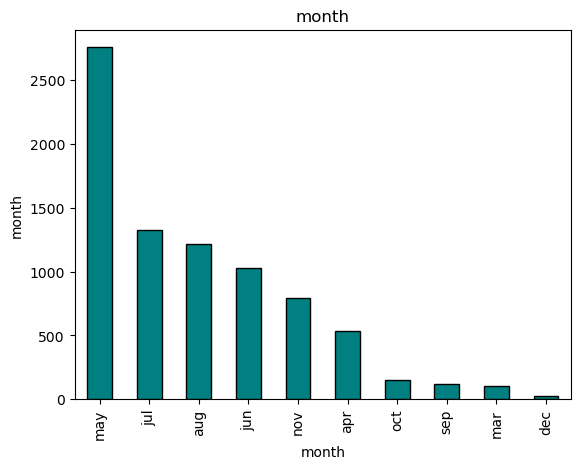

In [248]:
# Analyze Month
df_train['month'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title('month')
plt.xlabel('month')
plt.ylabel('month')
plt.show()

In [249]:
# Create a copy of the DataFrame to avoid modifying the original data
df_train_copy_c = df_train.copy()

# Define a mapping for specific months
quarter_mapping = {'dec': 'QuarterEnd', 'sep': 'QuarterEnd', 'jun': 'QuarterEnd', 'mar': 'QuarterEnd'}

# Replace specified months with 'QuarterEnd' in the copied DataFrame
df_train_copy_c['month_mapped'] = df_train_copy_c['month'].replace(quarter_mapping)

# Replace other months with 'others' in the copied DataFrame
df_train_copy_c['month_mapped'].replace(to_replace=df_train_copy_c['month_mapped'][~df_train_copy_c['month_mapped'].isin(['QuarterEnd'])].unique(), value='others', inplace=True)

# Display the value counts of the new variable
print(df_train_copy_c['month_mapped'].value_counts())

df_train['month'] = df_train_copy_c['month_mapped']
df_train['month'].value_counts()

others        6776
QuarterEnd    1275
Name: month_mapped, dtype: int64


others        6776
QuarterEnd    1275
Name: month, dtype: int64

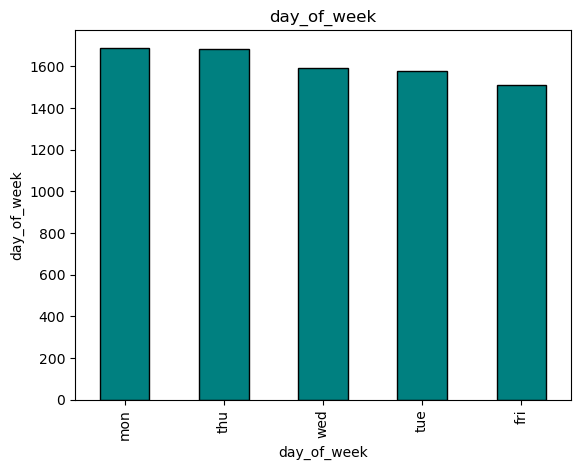

In [250]:
# Day_of_week
df_train['day_of_week'].value_counts().plot(kind='bar', color='teal', edgecolor='black')
plt.title('day_of_week')
plt.xlabel('day_of_week')
plt.ylabel('day_of_week')
plt.show()

In [251]:
# Label encoding
df_train['day_of_week'] = df_train['day_of_week'].map({'mon': 'WeekBeginning', 'tue': 'WeekBeginning','wed':'WeekBeginning',
                                                                      'thu':'WeekEnding','fri':'WeekEnding'})

# Display the updated DataFrame
df_train['day_of_week'].value_counts()

WeekBeginning    4859
WeekEnding       3192
Name: day_of_week, dtype: int64

In [252]:
# Feature engineering of other variables

# pdays
conditions = [
    (df_train['pdays'] == 999),
    (df_train['pdays'] < 5),
    ((df_train['pdays'] >= 5) & (df_train['pdays'] <= 10)),
    (df_train['pdays'] > 10)
]

choices = ['first visit', 'less than 5 days', '5 to 10 days', 'greater than 10 days']

# Create the 'pduration' column based on conditions
df_train['pduration'] = np.select(conditions, choices, default='unknown')

# pmonths
conditions = [
    (df_train['pmonths'] == 999),
    (df_train['pmonths'] <= 0.2),
    (df_train['pmonths'] > 0.2)
]

choices = ['first visit', 'less than 2 months',  'greater than 2 months']

# Create the 'pduration' column based on conditions
df_train['pduration_m'] = np.select(conditions, choices, default='unknown')


In [253]:
df_train.dtypes

custAge              float64
profession            object
marital               object
schooling             object
default               object
housing               object
loan                  object
contact               object
month                 object
day_of_week           object
campaign             float64
pdays                float64
previous             float64
poutcome              object
emp.var.rate         float64
cons.price.idx       float64
cons.conf.idx        float64
euribor3m            float64
nr.employed          float64
pmonths              float64
pastEmail            float64
responded             object
employment_status     object
pduration             object
pduration_m           object
dtype: object

# One-hot encode for categorical columns and continues features

In [254]:
# One hot encoding and normalization of appropriate variables 

X = df_train.drop(['responded', 'pdays','pmonths','employment_status'], axis=1)
y = df_train['responded']

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=['loan', 'marital', 'schooling', 'default', 'housing', 'day_of_week',
                                       'poutcome', 'pduration','pduration_m','profession','month','contact' ],drop_first=True)

# Identify continuous columns for normalization
continuous_columns = ['custAge','campaign','previous', 'emp.var.rate','cons.price.idx','cons.conf.idx',
                      'euribor3m','nr.employed','pastEmail'
                       ]


In [255]:
# Extracting the continuous columns from X_encoded
X_continuous = X_encoded[continuous_columns]

# StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the continuous data
X_continuous_normalized = scaler.fit_transform(X_continuous)

# Replace the original continuous columns in X_encoded with the normalized ones
X_encoded[continuous_columns] = X_continuous_normalized

In [256]:
X_encoded.columns

Index(['custAge', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'pastEmail',
       'loan_unknown', 'loan_yes', 'marital_Unknown', 'marital_married',
       'schooling_Uneducated&BasicEducation', 'schooling_Unknown',
       'default_Yes&Unknown', 'housing_unknown', 'housing_yes',
       'day_of_week_WeekEnding', 'poutcome_nonexistent', 'poutcome_success',
       'pduration_first visit', 'pduration_greater than 10 days',
       'pduration_less than 5 days', 'pduration_m_greater than 2 months',
       'pduration_m_less than 2 months', 'profession_Unemployed&Unknown',
       'profession_Working', 'month_others', 'contact_telephone'],
      dtype='object')

# Model Selection, Model Training, Model Validation

 Choosing the most appropriate model that can be used for this project.
 Split the data into train & test sets and use the train set to estimate the best model parameters.
 Evaluate the performance of the model on data that was not used during the training process. The goal is to estimate the    
 model'sability to generalize to new, unseen data and to identify any issues with the model, such as overfitting. 

Data is highly imbalanced need to mixed sampling it by using the SMOTE-NN method.

In [279]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [280]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=78)

Using the GridSearchCV for hyperparameter tuning for the accuracy

In [334]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [335]:
rf = RandomForestClassifier()

In [336]:
# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 20, 30]})

In [337]:
# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 30}
Best score:  0.9


In [338]:
# Evaluate the model performance (accuracy)
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8603351955307262


Using ensemble classifier with random forest, rbf for SVC and hard probability voting for display classification report

In [339]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [340]:
# Apply SMOTEENN to the training data
smoteenn = SMOTEENN(random_state=78)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

In [341]:
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=78)

In [342]:
# Create a Linear Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='rbf', probability=True, random_state=78)

In [343]:
# Ensemble the classifiers using a Voting Classifier
 # Hard for probability voting
ensemble_classifier = VotingClassifier(estimators=[
    ('rf', rf),
    ('svm', svm_classifier)
], voting='hard') 

In [344]:
# Fit the ensemble model on the resampled training data
ensemble_classifier.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=78)),
                             ('svm', SVC(probability=True, random_state=78))])

In [345]:
# Make predictions on the test set
y_pred = ensemble_classifier.predict(X_test)

In [346]:
# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86


In [347]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          no       0.94      0.90      0.92      1426
         yes       0.42      0.53      0.47       185

    accuracy                           0.86      1611
   macro avg       0.68      0.72      0.69      1611
weighted avg       0.88      0.86      0.87      1611



In [348]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

In [349]:
# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1288  138]
 [  87   98]]


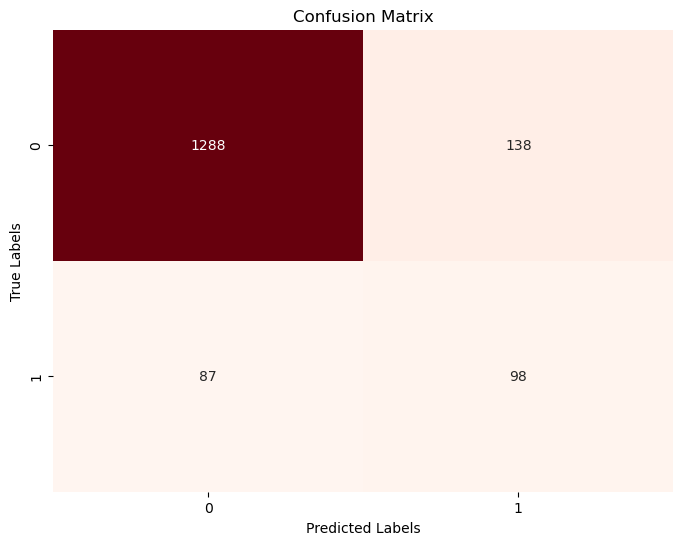

In [350]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [351]:
# Display number of true positives, true negatives, false positives, and false negatives
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

True Positives: 98
True Negatives: 1288
False Positives: 138
False Negatives: 87


Improved marketing campaign targeting, leading to higher conversion rates. Reduced marketing costs by focusing efforts on more likely customers. Data-driven decision making for customer acquisition strategies.
achieving this balance, the model optimizes the allocation of marketing resources, ensuring that the company maximizes its return on investment while efficiently reaching out to potential customers. This human-centered approach considers both the company's financial objectives and its goal of engaging with as many potential customers as possible, ultimately contributing to the company's growth and success.

In summary, comprehensive and well-maintained documentation is a cornerstone of operational excellence, supporting compliance, risk management, efficiency, knowledge sharing, and continuous improvement within a company. This ultimately supports operational excellence and long-term success.